# Name

Yuting Kou, Yizhou Wang, Yiming Xu, Ziyi Zhou

## Content

## Method

## Toy Example

In [1]:
import matplotlib.pyplot as plt
from autograd import numpy as np

from src.Inference import Inference
from src.Subspace import Subspace
from src.model import Model
from src.util import hidecode
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

In [2]:
data = np.load(r'.\example\data.npy')
x, y = data[:, 0], data[:, 1]


width = 7 #7
hidden_layers = 2 #2
input_dim = 1
output_dim = 1

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c) ** 2)


architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': 'rbf',
                'activation_fn_params': 'c=0, alpha=1',
                'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 127
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture)

# use MSE result as params_init
params = {'step_size': 1e-3, #1e-3
          'max_iteration': 5000, #5000
          'random_restarts': 1}
# my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

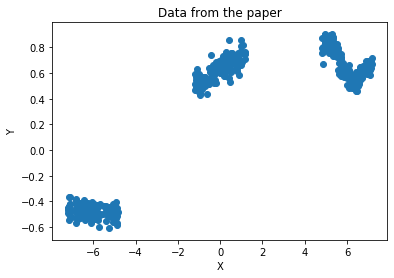

In [5]:
plt.scatter(x, y)
plt.title('Data from the paper')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [3]:
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture)
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w)
# my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w)

In [4]:
params = {'step_size': 1e-3,
              'max_iteration': 5000,
              'random_restarts': 1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=P, w_hat=w)

Iteration 0 lower bound 289.3001853084917; gradient mag: 990.2060364926602
Iteration 100 lower bound 107.0780461869004; gradient mag: 145.49567971593683
Iteration 200 lower bound 93.3218528910101; gradient mag: 43.398098804648946
Iteration 300 lower bound 87.36705042632238; gradient mag: 50.475779389227576
Iteration 400 lower bound 77.04110606687772; gradient mag: 72.61696586725112
Iteration 500 lower bound 55.119532462752275; gradient mag: 101.66465905368612
Iteration 600 lower bound 21.459547007887817; gradient mag: 101.59721452823686
Iteration 700 lower bound 5.814492834137534; gradient mag: 35.61176233636051
Iteration 800 lower bound 4.191846344429374; gradient mag: 7.386818658743635
Iteration 900 lower bound 3.919625535317178; gradient mag: 4.610261963649035
Iteration 1000 lower bound 3.7577506249513473; gradient mag: 3.947712295842036
Iteration 1100 lower bound 3.6264128529472606; gradient mag: 3.5485395929410664
Iteration 1200 lower bound 3.506089488255635; gradient mag: 3.29441

In [6]:
my_inference.train(X=x, y=y, warm_start=False, position_init=None)#,diagnostic_mode=False, step_size=1e-2, leapfrog_steps=10,
              #total_samples=2000, burn_in=0.1, thinning_factor=2, check_point=200)

[0.17640523 0.04001572 0.0978738  0.22408932]
Iteration 0 lower bound -28438.266829690456; gradient mag: 33074.16684741087


KeyboardInterrupt: 

In [ ]:

# get posterior z
n_sample = 10
post_sample = my_inference.get_posterior(n_samples=n_sample).reshape(-1, 2)
x_test = np.linspace(-8, 8, 100)
y_test = np.reshape(
    [my_nn.forward(P=P, w_hat=w, z=post_sample[i], X=x_test.reshape(1, -1)) for i in range(n_sample)],
    (n_sample, -1)) \
         + np.random.normal(0, my_nn.Sigma_Y_det ** 0.5, size=(n_sample, len(x_test)))
# because here Sigma_Y is 1-D, so determinants=its value

In [ ]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test, 0.25, axis=0), np.percentile(y_test, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()